## Import The Libaries 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import glob
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## **Display images and ground truth masks**


In [2]:
def plot_images_and_masks(data_folder):
    subfolders = ['dataA', 'dataB', 'dataC', 'dataD', 'dataE']
    num_images_to_plot = 3

    for subfolder in subfolders:
        image_subfolder_path = os.path.join(data_folder, subfolder, subfolder, 'CameraRGB')
        mask_subfolder_path = os.path.join(data_folder, subfolder, subfolder, 'CameraSeg')

        image_files = os.listdir(image_subfolder_path)[:num_images_to_plot]
        mask_files = os.listdir(mask_subfolder_path)[:num_images_to_plot]

        for i, (image_file, mask_file) in enumerate(zip(image_files, mask_files)):
            image = cv2.imread(os.path.join(image_subfolder_path, image_file))
            mask = cv2.imread(os.path.join(mask_subfolder_path, mask_file), cv2.IMREAD_GRAYSCALE)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f'Image {i+1} - {subfolder}')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title(f'Mask {i+1} - {subfolder}')
            plt.axis('off')

            plt.show()

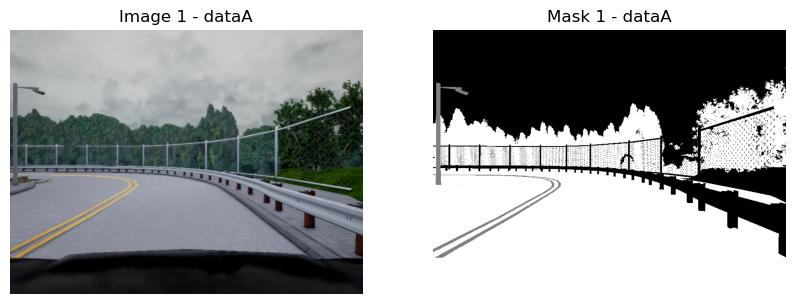

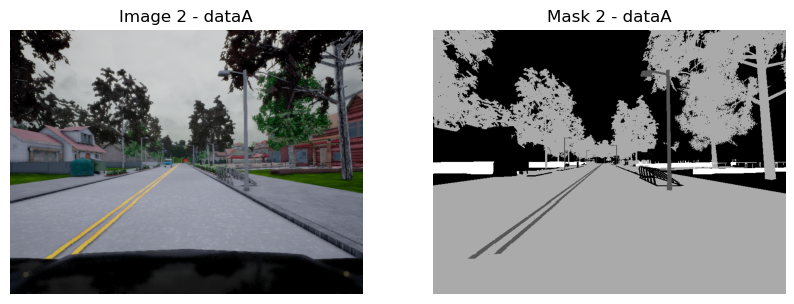

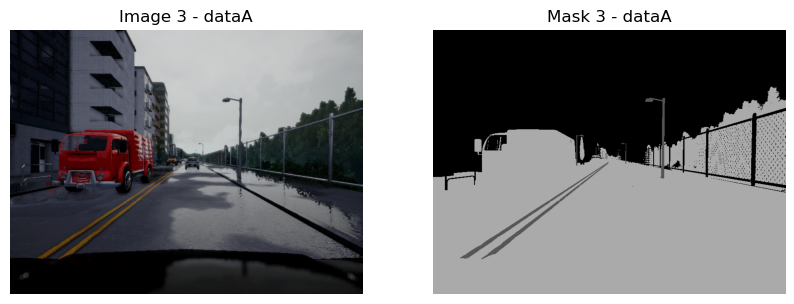

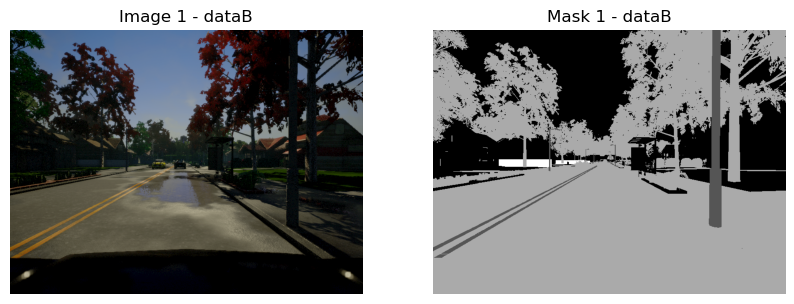

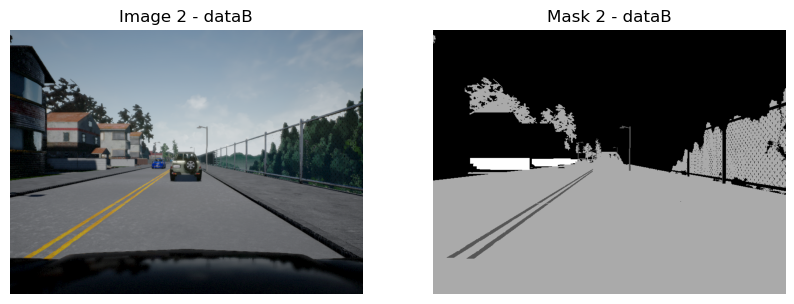

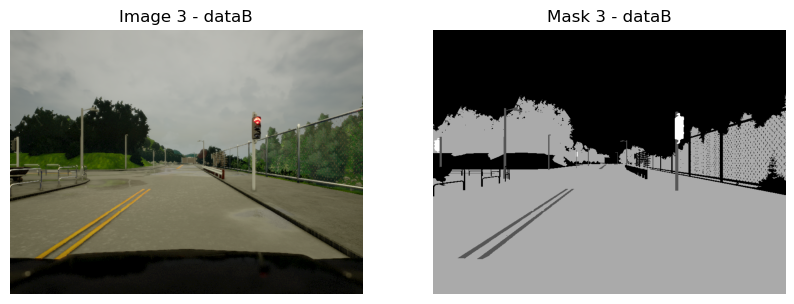

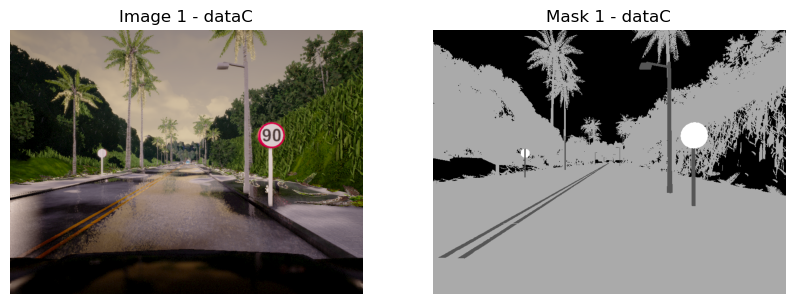

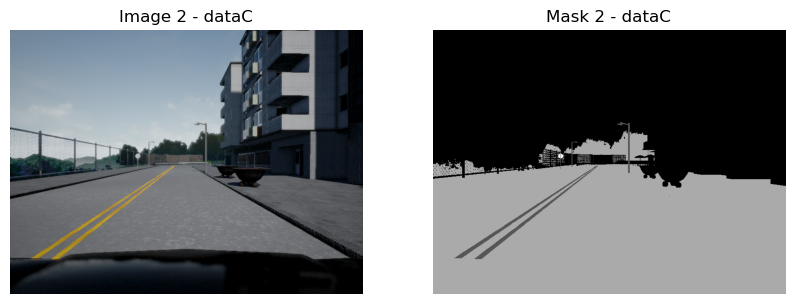

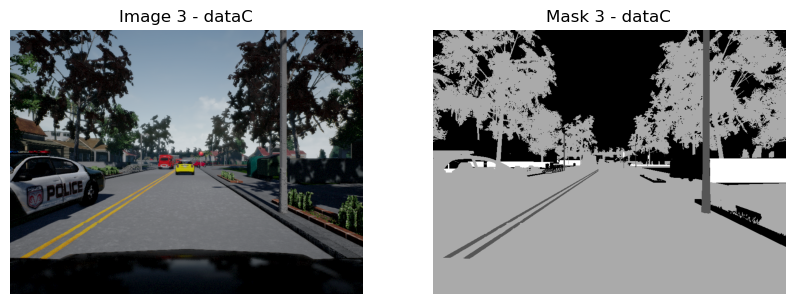

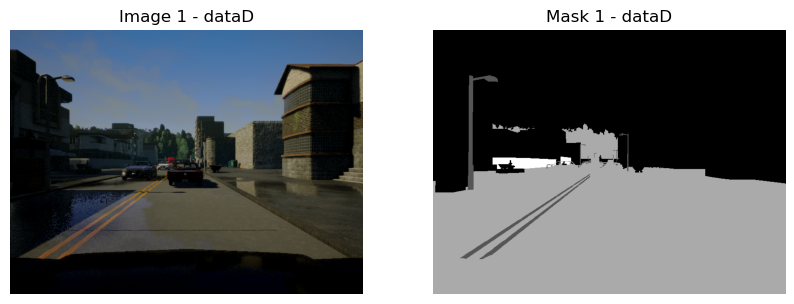

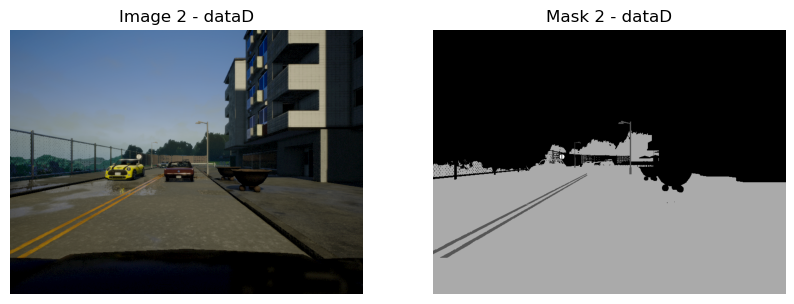

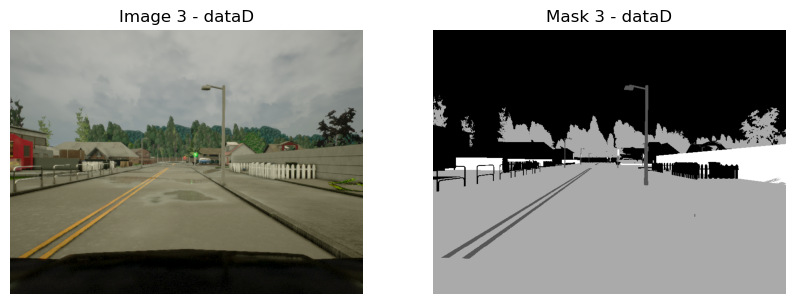

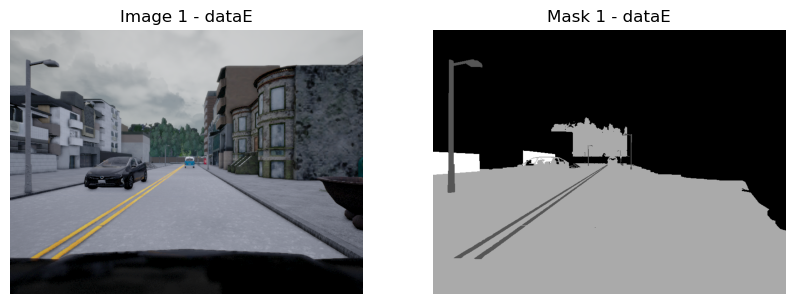

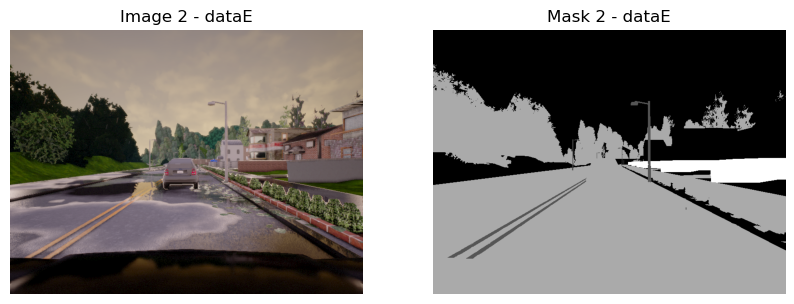

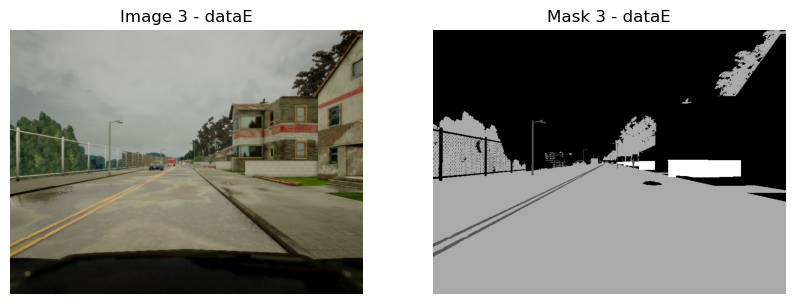

In [3]:
data_folder = "/kaggle/input/lyft-udacity-challenge"  
plot_images_and_masks(data_folder)

# storing images and masks in list

In [4]:
images_list = []
masks_list = []
def store_imgs_masks(data):
    images_list.append(glob.glob('/kaggle/input/lyft-udacity-challenge/'+data+'/'+data+'/CameraRGB/*.png'))
    masks_list.append(glob.glob('/kaggle/input/lyft-udacity-challenge/'+data+'/'+data+'/CameraSeg/*.png'))

In [5]:
store_imgs_masks('dataA')
store_imgs_masks('dataB')
store_imgs_masks('dataC')
store_imgs_masks('dataD')
store_imgs_masks('dataE')

In [6]:
from itertools import chain

def get_one_list(list_of_lists):
    return list(chain.from_iterable(list_of_lists))

In [7]:
images_list = get_one_list(images_list)
masks_list = get_one_list(masks_list)

In [8]:
print(images_list[50], '\n')
print(masks_list[50])

/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F62-70.png 

/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F62-70.png


# Transforming the lists  to tensors

In [9]:
image_list_ds = tf.data.Dataset.list_files(images_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(masks_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_010.png'>)


In [10]:
image_filenames = tf.constant(images_list)
masks_filenames = tf.constant(masks_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/F6-50.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/F6-50.png', shape=(), dtype=string)


# Preprocessing of images and masks

In [11]:
import tensorflow as tf

def process_and_preprocess(image_path, mask_path):
    # Load and preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Load and preprocess mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)

    # Resize image and mask
    img = tf.image.resize(img, (192, 256), method='nearest')
    mask = tf.image.resize(mask, (192, 256), method='nearest')

    return img, mask

image_ds = dataset.map(lambda image_path, mask_path: process_and_preprocess(image_path, mask_path))

In [12]:
uniques = set()

for img, mask in image_ds.take(5000):
    uniques.update(np.unique(mask.numpy()))
    
print("Number of classes: ", uniques)

Number of classes:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


# Building U-Net

In [13]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding='same')(inputs) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x) 
    
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if pool == True:
        p = MaxPool2D((2,2))(x) 
        return x, p 
    else:
        return x
    
    
def build_unet(shape, num_classes):  
    inputs = Input(shape)
    
    filters_x = [16,32,48,64,64,48,32,16]
    filters_b = [128] 

    # Encoder : Encoder path consist of 4 blocks
    # Encoder path is used to capture context (feature map) of input image in order to do segmentation
    x1, p1 = conv_block(inputs, filters_x[0], pool=True)
    x2, p2 = conv_block(p1, filters_x[1], pool=True)
    x3, p3 = conv_block(p2, filters_x[2], pool=True)
    x4, p4 = conv_block(p3, filters_x[3], pool=True)    
    
    # Bridge
    b1 = conv_block(p4, filters_b[0], pool=False) 

    u1 = UpSampling2D((2,2), interpolation='bilinear')(b1) 
    c1 = Concatenate()([u1, x4]) 
    x5 = conv_block(c1, filters_x[4], pool=False) 
    
    u2 = UpSampling2D((2,2), interpolation='bilinear')(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, filters_x[5], pool=False)
    
    u3 = UpSampling2D((2,2), interpolation='bilinear')(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, filters_x[6], pool=False)
    
    u4 = UpSampling2D((2,2), interpolation='bilinear')(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, filters_x[7], pool=False)
    
    # Output Layer
    output = Conv2D(num_classes, 1, padding='same', activation='softmax')(x8) 
    return Model(inputs, output)

In [14]:
## Define the resolution of the images and the number of classes

H = 192  
W = 256 
num_classes = 13
#calling function to build model
unet = build_unet((H, W, 3), num_classes)  

# Model summary

In [15]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 192, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

# Compiling models

In [16]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training models

In [17]:
EPOCHS = 50
BUFFER_SIZE = 1000
BATCH_SIZE = 64
map_dataset = image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Splitting data to training set and val set
num_samples = map_dataset.reduce(0, lambda x, _: x + 1).numpy()
train_dataset = map_dataset.take(int(0.8 * num_samples))
val_dataset = map_dataset.skip(int(0.8 * num_samples))
print(image_ds)

# ReduceLROnPlateau and EarlyStopping callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1,patience=1, min_lr=1e-6)
early_stop = tf.keras.callbacks.EarlyStopping(patience=2)

<_MapDataset element_spec=(TensorSpec(shape=(192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(192, 256, 1), dtype=tf.uint8, name=None))>


In [18]:
model_history1 = unet.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, callbacks=[reduce_lr,early_stop])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 [==============================] - 41s 318ms/step - loss: 1.3541 - accuracy: 0.7196 - val_loss: 2.0125 - val_accuracy: 0.5102 - lr: 0.0010
Epoch 2/50
63/63 [==============================] - 19s 303ms/step - loss: 0.7763 - accuracy: 0.9004 - val_loss: 1.9981 - val_accuracy: 0.5190 - lr: 0.0010
Epoch 3/50
63/63 [==============================] - 19s 304ms/step - loss: 0.5188 - accuracy: 0.9192 - val_loss: 1.6374 - val_accuracy: 0.5728 - lr: 0.0010
Epoch 4/50
63/63 [==============================] - 19s 304ms/step - loss: 0.3602 - accuracy: 0.9288 - val_loss: 1.6219 - val_accuracy: 0.5753 - lr: 0.0010
Epoch 5/50
63/63 [==============================] - 19s 303ms/step - loss: 0.2752 - accuracy: 0.9353 - val_loss: 1.3061 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 6/50
63/63 [==============================] - 19s 306ms/step - loss: 0.2288 - accuracy: 0.9416 - val_loss: 0.9857 - val_accuracy: 0.7381 - lr: 0.0010
Epoch 7/50
63/63 [==============================] - 19s 309ms/step - loss: 

# Models' performance

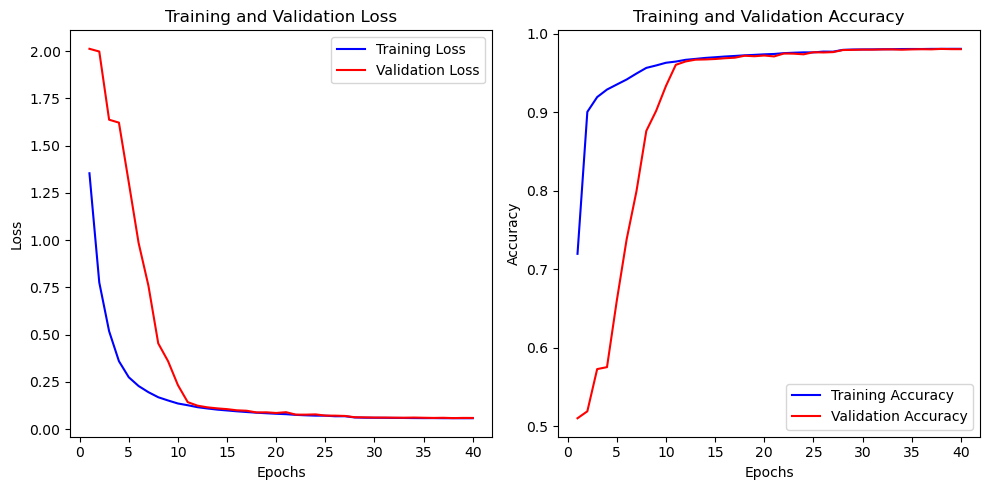

In [23]:
def plot_loss_and_accuracy(model_history):
    # Get the training and validation loss and accuracy values from the model history
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    train_accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_loss_and_accuracy(model_history1)

# Prediction

In [24]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [25]:
def show_predictions(unet = unet, dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

2/2 [==============================] - 0s 38ms/step


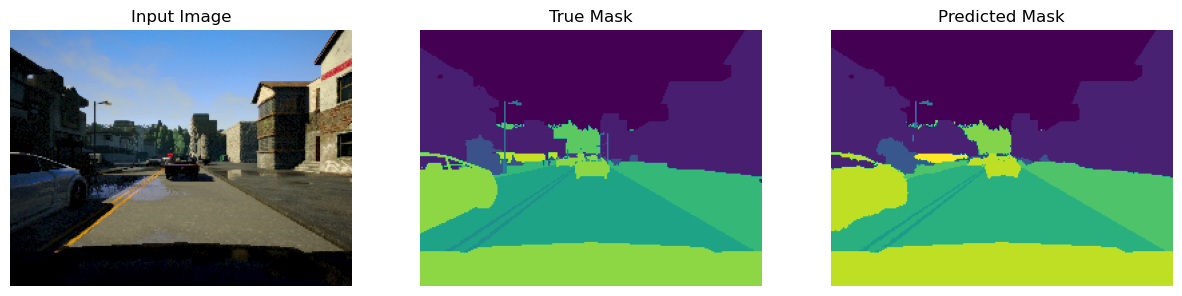

2/2 [==============================] - 0s 38ms/step


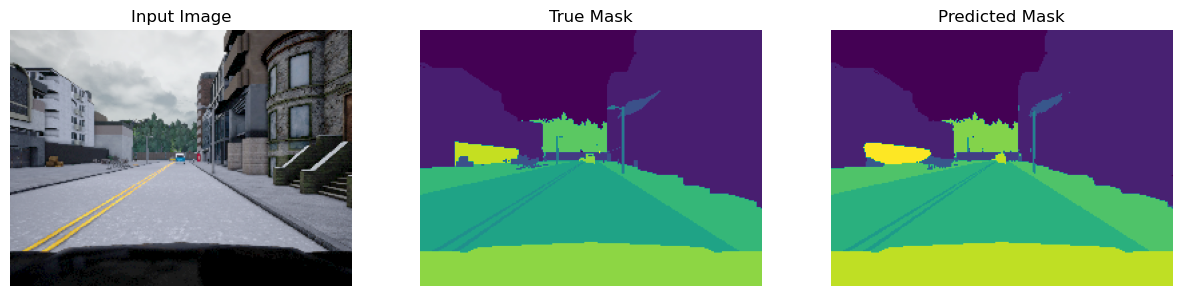

2/2 [==============================] - 0s 36ms/step


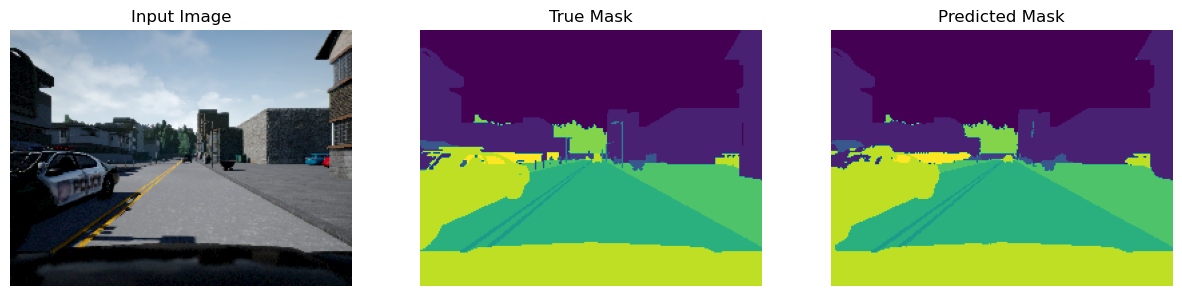

2/2 [==============================] - 0s 36ms/step


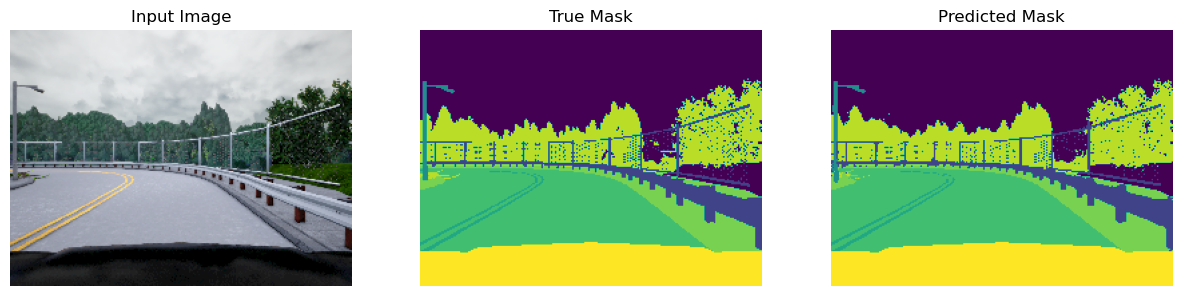

2/2 [==============================] - 0s 36ms/step


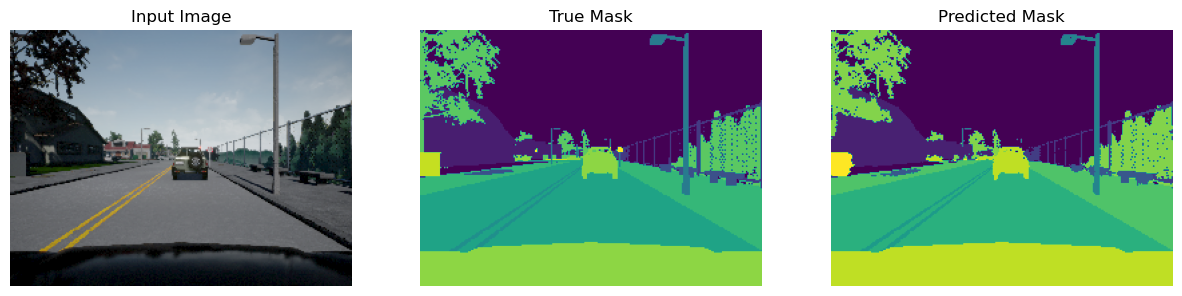

2/2 [==============================] - 0s 36ms/step


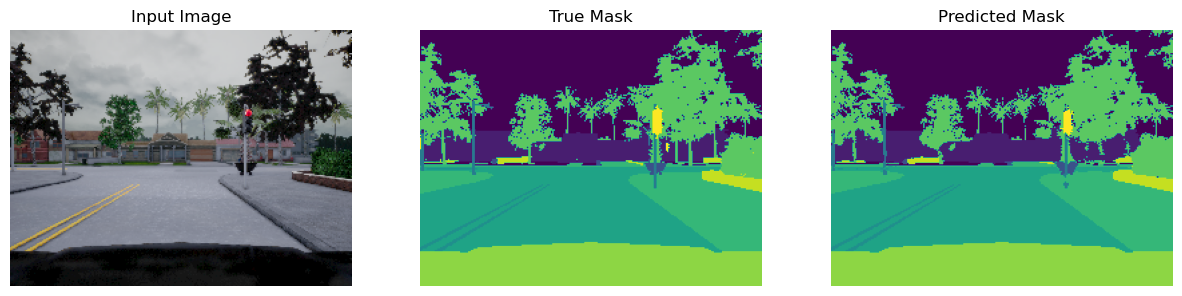

2/2 [==============================] - 0s 36ms/step


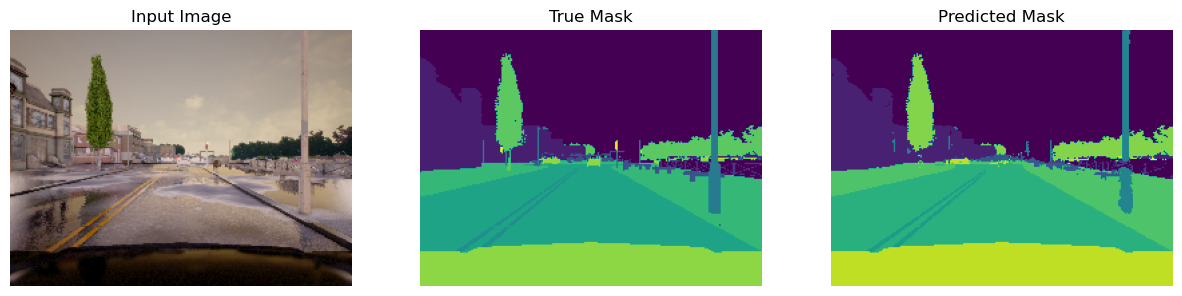

2/2 [==============================] - 0s 36ms/step


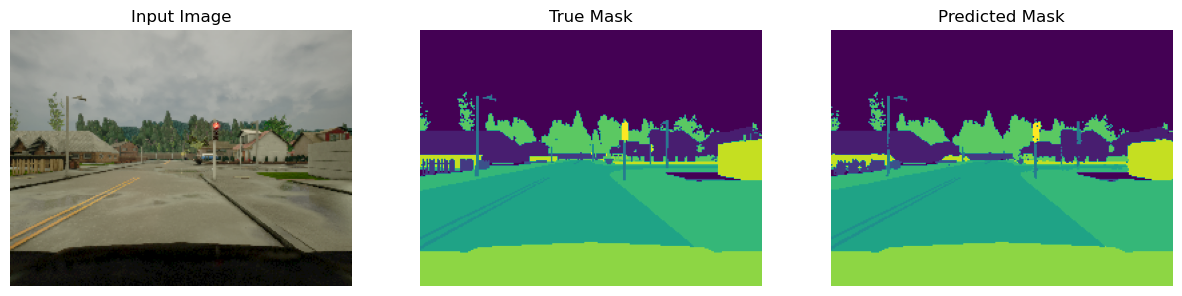

2/2 [==============================] - 0s 36ms/step


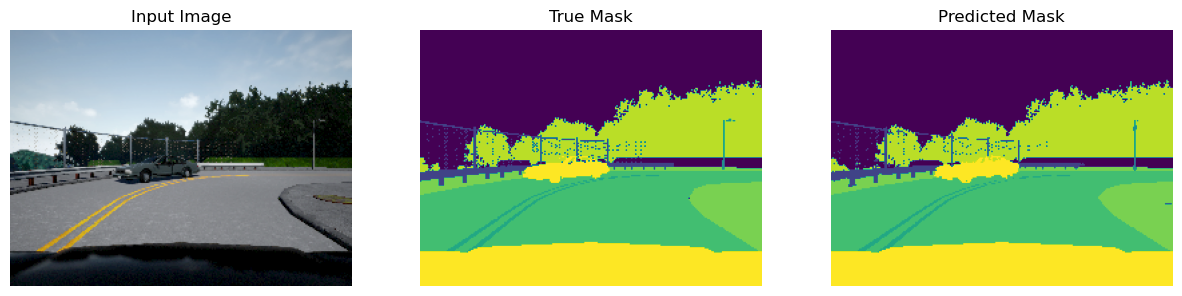

2/2 [==============================] - 0s 37ms/step


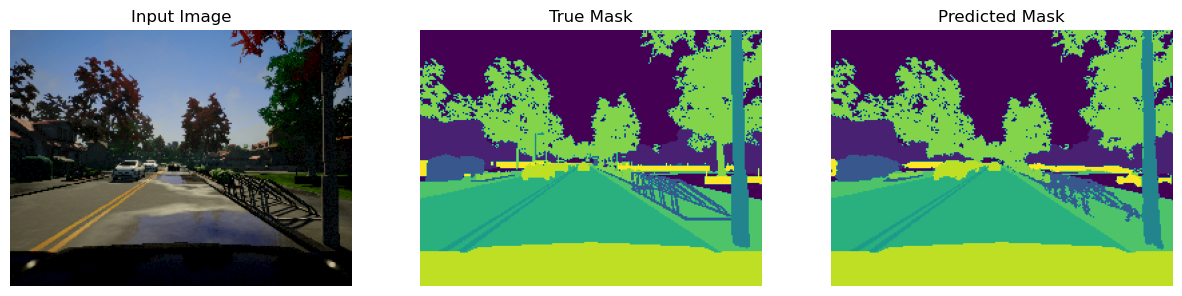

In [26]:
show_predictions(unet,train_dataset,10)